In [133]:
import aiohttp, http, asyncio, requests, re, time, os, json, pickle
from bs4 import BeautifulSoup
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import steam_tags_f as stf
import functools, random
from dotenv import load_dotenv


In [135]:
pd.options.display.float_format = '{:.2f}'.format
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 30)
pd.set_option('display.max_colwidth', 16)

In [137]:
%load_ext autoreload
%autoreload 2 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


GETTING THE TAGS AND MULTIPLAYER INFO

In [37]:
url = "http://api.steampowered.com/ISteamApps/GetAppList/v2/"
load_dotenv()
api_key = os.getenv("API_KEY")
params = {"key":api_key}

scode, data = stf.get_url(url, params=params, type = "api")
display(scode)


200

In [38]:
app_dict = {app['name']: app['appid'] for app in data['applist']['apps']}

In [39]:
top1000 = pd.read_csv('TOP 1000 Games cleaned.csv')

In [40]:
top1000["APP ID"] = 0

In [41]:
top1000_2 = stf.add_appid(top1000,app_dict)

C:\Users\JimiH\IRON HACK\WEEK 3\Project-3\steam_tags_f.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  title = row[0]
C:\Users\JimiH\IRON HACK\WEEK 3\Project-3\steam_tags_f.py:19: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Not Found' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df2.at[index, df2.columns[1]] = "Not Found"
C:\Users\JimiH\IRON HACK\WEEK 3\Project-3\steam_tags_f.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  title = row[0]


In [42]:
#top1000_2.to_csv('TOP 1000 Games cleaned AppId.csv', index=False)

In [43]:
#manually entered some app-ids that were not fetched
appid_fix = pd.read_csv('top_1000_games_cleaned_appid_fix.csv')

In [44]:
txt = pd.read_csv(r"top_1000_games_cleaned_appid_fix.csv")
txt = txt.rename({"Game Title":"title", "Steam App ID":"id"}, axis=1)
appid_list = list(txt["id"])

In [45]:
#tag_dict = stf.get_tags(appid_list)

In [46]:
with open ("tag_dict.pkl", "rb") as tag_dict_file:
    tag_dict = pickle.load(tag_dict_file)


In [47]:
appid_fix["tags"] = 0

#steam_df_tags = stf.add_tags(appid_fix,tag_dict)

In [48]:
with open ("steam_df_tags.pkl", "rb") as steam_df_tags_file:
    steam_df_tags = pickle.load(steam_df_tags_file)

In [49]:
#steam_df_tags.to_csv('steam_appid_tags.csv', index=False)

In [50]:
#mp_dict = stf.check_multiplayer(appid_list, token, delay=1)

In [51]:
with open ("steam_df_tags.pkl", "rb") as steam_df_tags_file:
    steam_df_tags = pickle.load(steam_df_tags_file)

with open ("mp_dict.pkl", "rb") as mp_dict_file:
    mp_dict = pickle.load(mp_dict_file)

In [52]:
steam_df_tags_mp = stf.add_mp(steam_df_tags, mp_dict)

C:\Users\JimiH\IRON HACK\WEEK 3\Project-3\steam_tags_f.py:137: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  id = row[1]


In [53]:
#steam_df_tags_mp.to_csv('steam_appid_tags_mp.csv', index=False)

In [54]:
tags_mp_dict = steam_df_tags_mp.set_index("Steam App ID")["tags"].to_dict()

In [ ]:
#with open ("tags_mp_dict.pkl", "wb") as tags_mp_dict_file:
    #pickle.dump(tags_mp_dict, tags_mp_dict_file)

FUNCTIONS

MAIN CODES

In [78]:
# creates the games id list
txt = pd.read_csv(r"top1k.csv")
txt = txt.rename({"Game Title":"title", "Steam App ID":"id"}, axis=1)
list_id = list(txt["id"])

In [ ]:
## main program, output

game_id_dict, error_list = stf.overall_fetch(list_id)

In [ ]:
# Saves our main source of information into a feather
output = pd.DataFrame.from_dict(game_id_dict)
output.to_feather("output.feather")

In [ ]:
# Saves our error results into an error csv
err_table = pd.DataFrame(error_list)
err_table.to_csv("error.csv")

In [80]:
### Bridges the webscrapping/API part with the cleaning and processing parts

# imports our feather database & gives us an idea of the shape/NaN's present
output = pd.read_feather("output.feather")
#display(output.isna().sum())
#display(output.shape)

In [82]:
# Cleans database of most recent games (so from Aug 2019 -> Present)
out2 = output.copy() 
filtered = out2.isna().sum(axis=0) > 85 ## 85 = Aug 2019
filter = filtered[filtered]

mask = list(filter.index)
for code in mask:
    out2.drop(code, axis = 1, inplace=True)

In [84]:
### New row 0 
out3 = out2.copy()

# Define a new row of zeroes with the same number of columns as df
zero_row = pd.DataFrame([[0] * len(out3.columns)], columns=out3.columns)

# Concatenate the new zero row at index 0
out4 = pd.concat([zero_row, out3]).reset_index(drop=True)

# imports the tags and the multiplayer tags dictionaries
with open ("steam_df_tags.pkl", "rb") as steam_df_tags_file:
    steam_df_tags = pickle.load(steam_df_tags_file)

with open ("mp_dict.pkl", "rb") as mp_dict_file:
    mp_dict = pickle.load(mp_dict_file)

# joins dictionaries
steam_df_tags_mp = stf.add_mp(steam_df_tags, mp_dict)

# creates the tags row and appends to out4
tags_mp_dict = steam_df_tags_mp.set_index("Steam App ID")["tags"].to_dict()
tags_mp_dict_str = {str(key):value for key, value in tags_mp_dict.items()}
out4_2 = stf.add_tags_df(out4, tags_mp_dict_str)

#display(out4_2)

C:\Users\JimiH\IRON HACK\WEEK 3\Project-3\steam_tags_f.py:137: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  id = row[1]


In [86]:
# Converts "Date" into DataFrame index
out5=out4_2.copy()

# creates a "Date" column
out5_extracted = out5["730"][1:].map(lambda x: x["Date"] if isinstance(x, dict) else x)

# takes appid "730" (which is one of the completed ones and uses it to define "Data" column)
out5["Date"] = out5_extracted # Adds the dates into column "Date"
out5["Date"][0] = "Tags" # Adds the Tags into row 0
out5.set_index("Date", inplace=True) # Sets column "Date" to be the index

#display(out5)

C:\Users\JimiH\AppData\Local\Temp\ipykernel_28156\1749885732.py:9: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  out5["Date"][0] = "Tags" # Adds the Tags into row 0


In [88]:
##### Converts columns into game's name
out6 = out5.copy()

# creates the id list
txt2 = txt.rename({"Game Title":"title", "Steam App ID":"id"}, axis=1)
txt2 = txt2[["id","title"]]
txt2.set_index("id", inplace=True)

# Create a mapping from ids to titles
title_mapping = {str(k): v for k, v in txt2["title"].to_dict().items()}

# Rename the columns in out4 using the mapping
out6.columns = [title_mapping.get(str(col), col) for col in out4.columns]

# Creates our main dataframe visualization 
visual = "Peak Players" # DB issue, needs fixing
out6 = out6.apply(lambda x: x.apply(lambda y: y.get(visual) if isinstance(y, dict) and visual in y else y), axis=0)
out6[1:] = round(out6[1:].fillna(0).astype(float),0).astype(int)

#display(out6)

In [90]:
# More cleaning while looking at data. Disregarding outliers etc..
out7 = out6.copy()

## Drops bot-afflicted games that warped data == Outlier
out7.drop("POSTAL", axis=1, inplace=True)

# Creates a new column (Total) and concats into the existing dataframe
out7["Total"]=0
out7.loc[out7.index[1:], 'Total'] = out7.iloc[1:, :].sum(axis=1)

#display(out7)

C:\Users\JimiH\AppData\Local\Temp\ipykernel_28156\4202117265.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[3429549 3658113 3756092 3713895 3709978 3733392 3687320 3418189 3588807
 3518863 3154667 3223690 3378453 3451318 3600567 3507329 3552935 3496826
 3376390 3351206 3512241 3301614 3104668 3009852 3039494 3142713 3168360
 3064813 2953866 3001935 2950483 3195762 3408226 3070960 2890328 2784883
 2843418 3037818 3052718 2990626 3125787 3253986 3194720 3385818 3532191
 3235902 3111485 3026232 2963173 2999147 3114013 3135072 3556543 3816362
 3360552 3011553 2924026 2737791 2455168 2338818 2484725 2737076 2837606
 2845586 2766092 2615432 2833079 2783614 2972302 2859397 2535688 2529091
 2721237 2852288 2836226 2959193 2849198 3084891 3410407 3551059 3894652
 3663215 3355386 3087950 2654060 2534670 2423108 2330042 2111938 2127665
 2080546 2170158 2209763 2068701 1954157 1970079 1811119 1969580 2004151
 

In [92]:
# Adds Z-Column
out8 = out7.copy()

out8['Z'] = 0 # creates an empty column named "Z"
out8['Z'][1:] = stf.z_norm(out8['Total'][1:]) # adds Z-normalized values into Z column

C:\Users\JimiH\AppData\Local\Temp\ipykernel_28156\6564845.py:5: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  out8['Z'][1:] = stf.z_norm(out8['Total'][1:]) # adds Z-normalized values into Z column
C:\Users\JimiH\AppData\Local\Temp\ipykernel_

## DATA VISUALIZATION ##

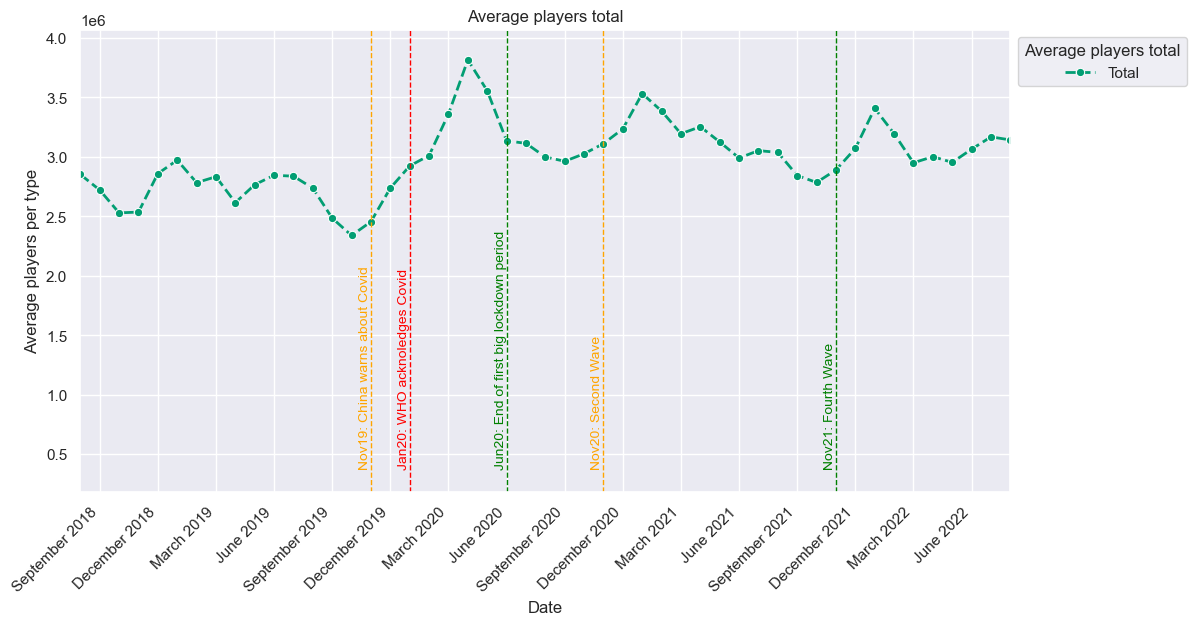

In [153]:
stf.t_plot(out8,["Total"],"Average players total","y")

In [97]:
list_tags =[value.split(",") for value in tags_mp_dict.values()]
list_tags
set_tags = {item.strip() for sublist in list_tags for item in sublist}

#list(set_tags)

In [99]:
# creates the dataframes for all the game_types defined
game_types = ['Racing', 'Sports', 'RPG', 'Action', 'Casual', 'Adventure', 'Indie', 'Simulation', 'Strategy', 'Multi-player', 'Co-op']

# creates a dictionary with all the dataframes created
lgames = {}

for game in game_types:
    globals()[f"{game}_df"] = stf.make_type(out8, game)
    lgames[f"{game}_df"] = globals()[f"{game}_df"]
    

C:\Users\JimiH\IRON HACK\WEEK 3\Project-3\steam_tags_f.py:301: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  output[substring]=0
C:\Users\JimiH\IRON HACK\WEEK 3\Project-3\steam_tags_f.py:302: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[54765 42278 43322 45437 45511 46930 46393 44783 45529 45659 41557 43716
 45927 45386 48434 44829 44106 46741 47468 47233 49710 48306 40352 40440
 42321 40162 42516 42920 41175 42563 40879 43378 48100 47488 46882 47316
 48098 51522 53218 54822 59586 68949 65138 68539 75251 80665 81036 83411
 63334 52347 53427 51743 57470 67039 59503 49860 50755 49189 39263 39559
 38443 37941 41403 42243 42376 38976 39530 37600 40215 41901 37816 397

In [101]:
# compresses all the common types: ['Racing', 'Sports']
sports_df = pd.concat([Racing_df, Sports_df], axis=1)
sports_df["sports"]=sports_df.sum(axis=1)
sports_df.drop(['Sports','Racing'], axis=1, inplace = True)
sports_df.rename(columns={"sports": "Sports"}, inplace=True)

lgames["sports_df"]=sports_df

In [103]:
# creates a dataframe of a specific genre with a single column that contains the specified value 
df2 = out8.copy()

columns_to_keep = df2.columns[~df2.iloc[0].astype(str).str.strip().str.contains("Multi-player")]
output = out8[columns_to_keep].copy()

# Step 2: Ensure all relevant columns are numeric
for col in output.columns:
    output[col] = pd.to_numeric(output[col], errors='coerce')

# Step 3: Add "not multi-player" column by summing numeric values, ignoring the first row
output["not Multi-player"] = output.iloc[1:, :].sum(axis=1)  # Sum from the second row onward

# Step 4: Subtract the "Total" for each relevant row
output["not Multi-player"] = output["not Multi-player"] - pd.to_numeric(out8.iloc[1:, out8.columns.get_loc("Total")], errors='coerce')

# Step 5: Ensure values do not exceed the total (if needed)
output["not Multi-player"] = output["not Multi-player"].clip(lower=0)  # Avoid negative values

# Step 6: Filter the resulting DataFrame for "not multi-player"
not_mp_df = output.filter(like="not Multi-player", axis=1)

#not_mp_df

C:\Users\JimiH\AppData\Local\Temp\ipykernel_28156\2359203602.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  output["not Multi-player"] = output.iloc[1:, :].sum(axis=1)  # Sum from the second row onward


In [105]:
# removes old dataframes from the list 

pop_keys = ['Racing_df', 'Sports_df']

for key in pop_keys:
    lgames.pop(key, None)

# makes a single dataframe with the total average per gametype
lgames_upd=None

for df in lgames.values():
    if lgames_upd is None:
        lgames_upd = df
    else:
        lgames_upd = pd.merge(lgames_upd, df, left_index=True, right_index=True)

lgames_upd["not Multi-player"] = not_mp_df
lgames_upd["Total"] = out7["Total"]
#display(lgames_upd)

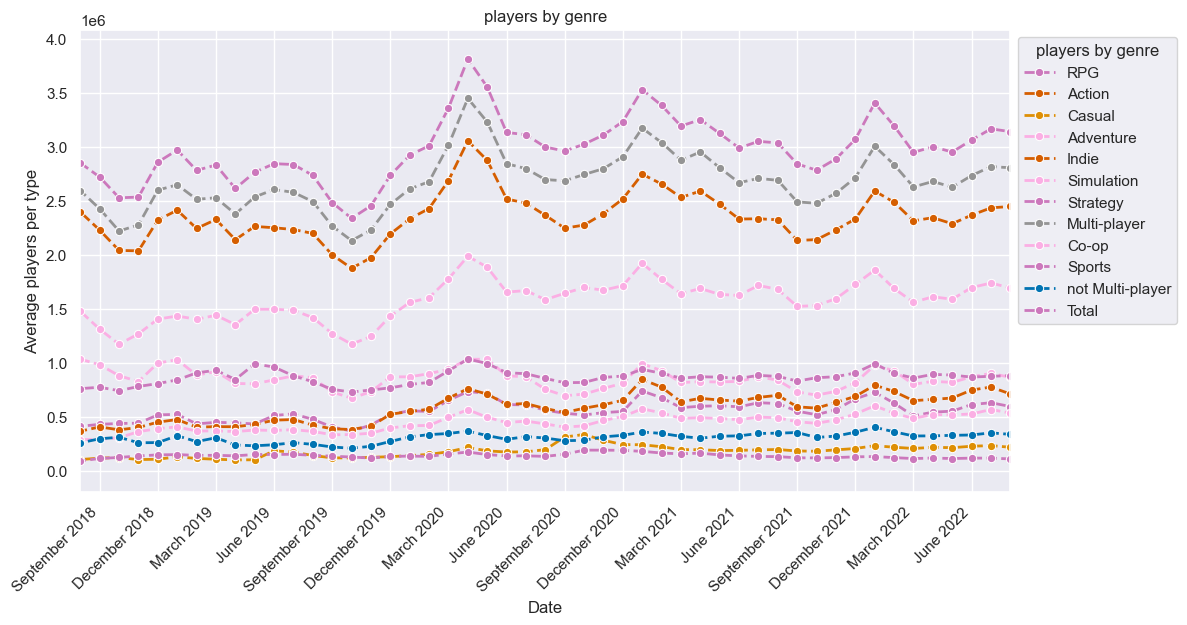

In [141]:
stf.t_plot(lgames_upd,list(lgames_upd.columns),"players by genre","n")

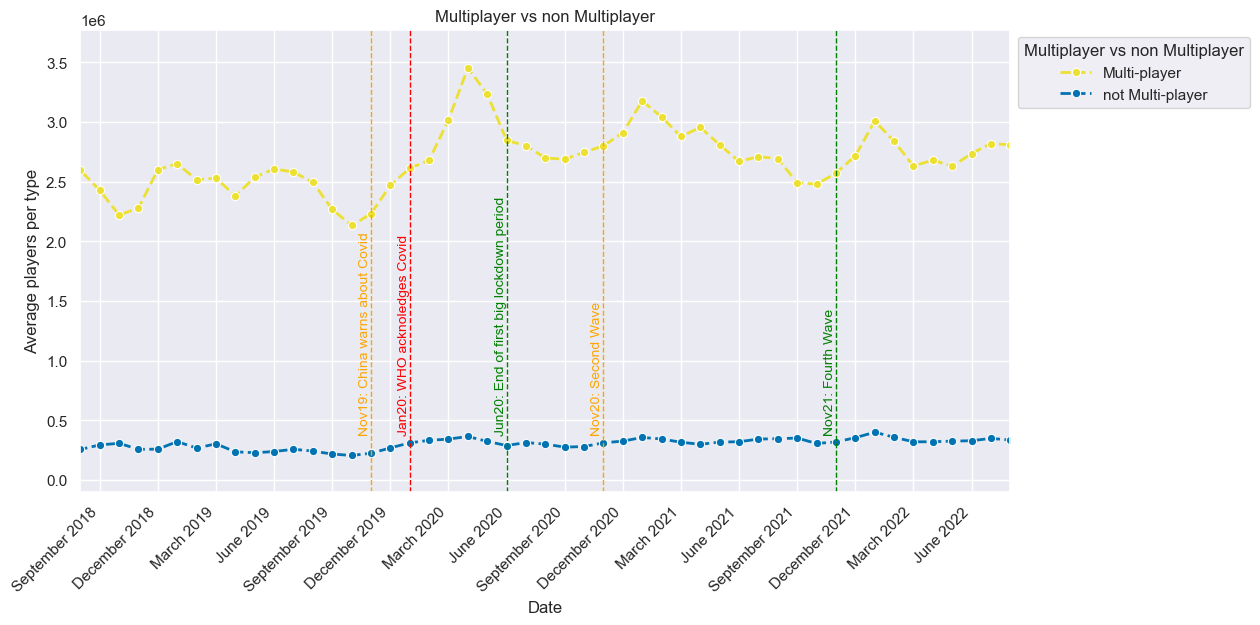

In [151]:
stf.t_plot(lgames_upd,["Multi-player", "not Multi-player"],"Multiplayer vs non Multiplayer","y")